In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/summer2024/group project
# !ls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [28]:
# data = pd.read_csv('rawdata/sandiego.csv')
# data = pd.concat([pd.read_csv('rawdata/sandiego.csv'), pd.read_csv('rawdata/losangeles.csv')])
data = pd.read_csv('./data/US/combined_listings.csv')
# data.describe()

C:\Users\sangd\AppData\Local\Temp\ipykernel_7672\3409917006.py:3: DtypeWarning: Columns (28,29,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/US/combined_listings.csv')


In [31]:
data = data[['name', 'description', 'neighborhood_overview','host_about', 'room_type', 'amenities', 'price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']]

In [5]:
data.head()

,name,description,neighborhood_overview,host_about,room_type,amenities,price
0,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, ne...",NaN,"Husband, father, MIT MBA, Silicon Valley-based...",Entire home/apt,"[""Refrigerator"", ""Dryer"", ""TV with standard ca...",$129.00
1,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,"Run Runyon Canyon, Our Gym & Sauna Open <br />...","Walk and run to Runyon Canyon, it is open!<br ...",Professional and technical writer.\nLiterary C...,Private room,"[""Exercise equipment: elliptical, free weights...",$89.00
2,"The Wolford House, a Mid Century Hilltop Jewel",Gather for sun-dappled alfresco lunches at a s...,"Tucked away atop Mount Washington, the propert...",We live in our new house next door to the Wolf...,Entire home/apt,"[""Dishwasher"", ""Fireplace guards"", ""Free stree...",$450.00
3,Zen Life at the Beach,An oasis of tranquility awaits you.,"This is the best part of Santa Monica. Quiet, ...",I have been teaching yoga and meditation for 3...,Private room,"[""Free street parking"", ""Refrigerator"", ""Dryer...",$139.00
4,Charming accommodations in Westwood/West LA,"Central, convenient, cozy 3room accommodations...","quiet, residential, safe, easy frwy access( (p...","Is easy going , a bit of a clean freak, very ...",Entire home/apt,"[""Free street parking"", ""Ceiling fan"", ""Refrig...",$101.00


In [34]:
# data.dropna(inplace=True)
data.isnull().sum()

name                     0
description              0
neighborhood_overview    0
host_about               0
room_type                0
amenities                0
price                    0
longitude                0
latitude                 0
accommodates             0
bathrooms                0
bedrooms                 0
beds                     0
minimum_nights           0
review_scores_rating     0
number_of_reviews        0
dtype: int64

In [33]:
data = data.dropna(subset=['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews'])
data = data.fillna('')
data.shape

(185220, 16)

In [35]:
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
def MinMaxScaler(data):
    MIN = data.min()
    MAX = data.max()
    return MIN, MAX, (data - MIN) / (MAX - MIN)
# MIN, MAX, data['price'] = MinMaxScaler(data['price'])

In [40]:
# prompt: vocabs = [], for each columns, split the strings by all punctuation marks and ' ', append every word to vocabs. assign the cell values with splitted words

import re

# Initialize an empty list to store vocabulary words
vocabs = []
# List of columns to process
columns = ['name', 'description', 'neighborhood_overview', 'host_about', 'room_type', 'amenities']



# for col in columns:
#     new_col = []
#     for i in range(len(data[col])):
#       cell_value = data[col][i]
#       if pd.isna(cell_value):
#           new_col.append([])
#       elif isinstance(cell_value, str):
#         words = re.split(r'[,\s.;!?\'\"\[\]\(\)\{\}*/-]+', cell_value)
#         words = [word.lower() for word in words if word]
#         for word in words:
#             if word not in vocabs:
#                 vocabs.append(word)
#         new_col.append(words)
#     new_data.append(new_col)

stop_words = {'the', 'is', 'in', 'it', 'and', 'to', 'of', 'a', 'that', 'with', 'as', 'for', 'on', 'this', 'by', 'an', 'at', 'or', 'from'}

def parse_words(cell_value, stop_words, htmls=['<br>', '</br>', '<p>', '</p>']):
    """
    Parse words from a given cell value, remove stop words and empty strings,
    and convert words to lowercase.

    Parameters:
    - cell_value (str): The text to be parsed.
    - stop_words (set): A set of stop words to be removed from the text.
    - htmls (list): A list of HTML tags to be replaced with spaces.

    Returns:
    - filtered_words (list): A list of parsed and filtered words.
    """
    # Replace HTML tags with spaces
    for html_tag in htmls:
        cell_value = cell_value.replace(html_tag, ' ')
    
    # Split the cell value into words using the specified delimiters
    words = re.split(r"[,\s.;!?\"\[\]\(\)\{\}*/\\\-]+", cell_value)
    
    # Remove stop words and empty strings, and convert to lowercase
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word != '']

    return filtered_words



In [41]:
new_data = [] # Initialize an empty list to store the processed data
# Process data row by row
for idx, row in data.iterrows():
    new_row = []  # Initialize a new list to store processed words for the current row
    for col in columns:
        cell_value = row[col]  # Get the cell value for the current column and row
        if pd.isna(cell_value):
            new_row.append([])
        else:
            if isinstance(cell_value, str):
                words = parse_words(cell_value, stop_words)
                for word in words:
                  vocabs.append(word.lower())  # Add the word to the vocabulary list in lowercase
                  new_row.append(word.lower())  # Add the word to the current row list in lowercase
    new_data.append(new_row)  # Add the processed row to the new_data list

In [42]:
vocabs = set(vocabs)
print(f"Total unique words: {len(vocabs)}")

Total unique words: 168315


In [43]:
print(new_data[2856])

['amazing', 'suite', 'bath', 'kitchenette', 'close', 'family', 'friendly', 'activities', 'nightlife', "it's", 'great', 'cul', 'de', 'sac', 'quiet', 'safe', 'neighborhood', 'close', 'quartz', 'hill', 'downtown', 'location', 'duplex', 'tenants', 'living', 'other', 'side', 'separate', 'private', 'gated', 'entrance', 'unit', 'stand', 'alone', 'completely', 'sealed', 'off', 'main', 'house', 'airbnb', 'fan', 'entire', 'home', 'apt', 'mid', 'size', 'dorm', 'fridge', 'refrigerator', 'portable', 'heater', 'hot', 'water', 'smoke', 'alarm', 'single', 'level', 'home', 'free', 'driveway', 'parking', 'premises', 'portable', 'air', 'conditioning', 'carbon', 'monoxide', 'alarm', 'microwave']


In [44]:
word_to_idx = {word: idx+1 for idx, word in enumerate(vocabs)}
idx_to_word = {idx+1: word for idx, word in enumerate(vocabs)}

In [15]:
def one_hot_encode_sentence(sentence, word_to_idx):
  encoded_sentence = np.zeros(len(word_to_idx))
  for word in sentence:
    encoded_sentence[word_to_idx[word]] += 1
  return encoded_sentence

def one_hot_encode(data, word_to_idx):
  vocab_size = len(word_to_idx)
  encoded_data = np.zeros((len(data), vocab_size))
  for row in range(len(data)):
    for word in data[row]:
      encoded_data[row][word_to_idx[word]] += 1
  return encoded_data


In [45]:
max=0
for row in new_data:
    if len(row)>max: max = len(row)
while max%4 != 0: max+=1
VOCAB_SIZE = len(vocabs) +1  # size of the vocabulary
CONTEXT_SIZE = max # the maximum number of words to consider in each context (row)
EMBEDDING_DIM = 128 # dimensionality of the embedding vectors
OUTPUT_DIM = 10

In [47]:
encoded_data = []

for row in new_data:
    # Initialize word indices and attention mask with zeros
    word_indices = [0] * CONTEXT_SIZE
    attention_mask = [0] * CONTEXT_SIZE

    for i in range(len(row)):
        word_indices[i] = word_to_idx[row[i]]
        attention_mask[i] = 1
    
    # Create a tensor that consists of two lists: word_indices and attention_mask
    encoded_row = torch.tensor([word_indices, attention_mask], dtype=torch.float32)
    encoded_data.append(encoded_row)

# Convert encoded_data to a tensor
encoded_data = torch.stack(encoded_data)   

In [49]:
# Min-Max normalization function
def min_max_normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

# Normalize y
y_np = min_max_normalize(data[['price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']]).values  # Convert to numpy array

y = torch.tensor(y_np, dtype=torch.float32)

# Create TensorDataset
dataset = torch.utils.data.TensorDataset(encoded_data, y)

# Shuffle dataset and split into training and testing sets
def train_test_split_tensor(dataset, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    
    # Split indices
    split_idx = int(len(dataset) * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create datasets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    
    return train_dataset, test_dataset

# Split dataset
train_dataset, test_dataset = train_test_split_tensor(dataset, test_size=0.2, random_state=42)

# Create DataLoaders for training and testing datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1280, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1280, shuffle=False)

In [53]:
import math

class MyWord2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(MyWord2Vec, self).__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim, 1)
        self.fc2 = nn.Linear(context_size, 10)
        self.init_weights()
    
    def init_weights(self):
        nn.init.xavier_uniform_(self.embed.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def positional_encode(self, x):
        # with torch.no_grad():
        position = torch.arange(0, x.size(1)).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, x.size(2), 2).float() * -(math.log(10000.0) / x.size(2)))
        pos_encoding = torch.zeros_like(x)
        pos_encoding[:, :, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, :, 1::2] = torch.cos(position * div_term)
        return x + pos_encoding

    def forward(self, x):
        word_indices = x[:, 0].long()
        attention_mask = x[:, 1]
    
        x = self.embed(word_indices)
        # print(x[128][1240])
        # print('after embed ', x.shape)
        # x = self.positional_encode(x)
        # print('after pe ', x.shape)
        # x = x * attention_mask.unsqueeze(-1)  # Apply attention mask
        # x = x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)  # Mean pooling
        x = self.fc1(x)
        # print('after fc1 ', x.shape)
        x = x.squeeze()
        # print('after squeeze ', x.shape)
        x = self.fc2(x).squeeze()  # Apply context-aware linear layer
        # print('after fc2 ', x.shape)
        return x

In [54]:
# Initialize the model
model = MyWord2Vec(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

# Example training loop (add L1 regularization and early stopping)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopping_patience = 10
l1_lambda = 0.01

In [22]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs.squeeze(), targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * len(inputs)

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                # Forward pass
                outputs = model(inputs)
                loss = loss_function(outputs.squeeze(), targets)

                epoch_val_loss += loss.item() * len(inputs)

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses


In [55]:
num_epochs = 10  # Set the number of epochs
train_losses, val_losses = train_model(model, train_dataloader, test_dataloader, num_epochs=num_epochs)

Epoch 1/10 - Train Loss: 44.9334, Val Loss: 18.1157
Epoch 2/10 - Train Loss: 14.8696, Val Loss: 14.0428
Epoch 3/10 - Train Loss: 12.7602, Val Loss: 13.2096
Epoch 4/10 - Train Loss: 11.8050, Val Loss: 12.7784
Epoch 5/10 - Train Loss: 11.2030, Val Loss: 12.6620
Epoch 6/10 - Train Loss: 10.7927, Val Loss: 12.4811
Epoch 7/10 - Train Loss: 10.4970, Val Loss: 12.4165
Epoch 8/10 - Train Loss: 10.2386, Val Loss: 12.4182
Epoch 9/10 - Train Loss: 10.0450, Val Loss: 12.4265
Epoch 10/10 - Train Loss: 9.9002, Val Loss: 12.4161


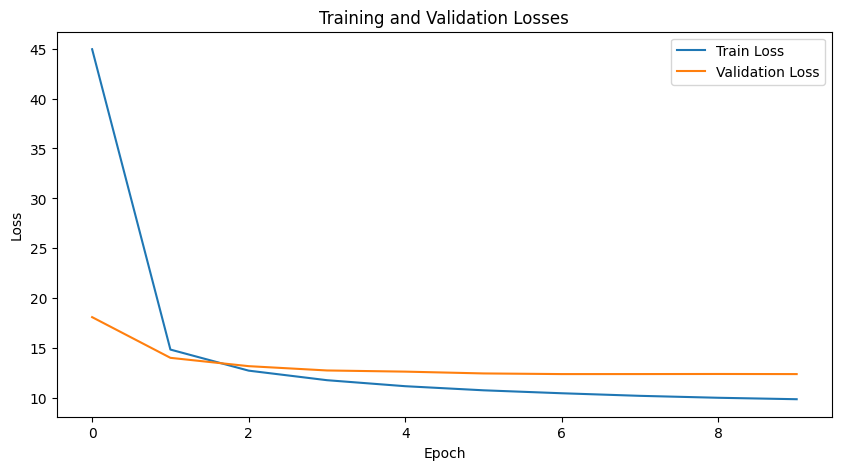

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [57]:
def get_vector(word, word_to_idx, model):
    """
    Retrieve the embedding vector for a given word from the weights of fc1 in the model.
    
    Parameters:
    - word (str): The word whose embedding vector is to be retrieved.
    - word_to_idx (dict): Dictionary mapping words to their indices.
    - model (torch.nn.Module): The neural network model containing the fc1 layer.
    
    Returns:
    - torch.Tensor: The embedding vector for the given word.
    """
    # Ensure the word is in the vocabulary
    if word not in word_to_idx:
        raise ValueError(f"Word '{word}' not found in vocabulary.")
    
    # Convert the word to its index
    word_idx = word_to_idx[word]
    
    # Retrieve the embedding vector from the fc1 weights
    # model.fc1.weight is of shape (VOCAB_SIZE, EMBEDDING_DIM)
    # We need the row corresponding to the word index
    embedding_vector = model.embed.weight[word_idx]
    
    return embedding_vector
 

In [58]:
a = get_vector('hello', word_to_idx, model)
print(a.shape)

torch.Size([128])


In [59]:
def find_closest_words(word, word_to_idx, idx_to_word, model, num_w):
    """
    Find and print the closest words to a given word based on their embedding vectors.
    
    Args:
    - word (str): The word to find closest words for.
    - word_to_idx (dict): Mapping from words to indices.
    - idx_to_word (dict): Mapping from indices to words.
    - model (torch.nn.Module): The model containing the embedding weights.
    - num_w (int): Number of closest words to find.
    """
    word_vector = get_vector(word, word_to_idx, model)
    
    # Get all word vectors
    all_vectors = model.fc1.weight.T
    
    # Compute cosine similarities between the word vector and all other vectors
    similarities = F.cosine_similarity(word_vector.unsqueeze(0), all_vectors)
    
    # Get the indices of the top `num_w` most similar vectors
    _, top_indices = similarities.topk(num_w + 1)  # +1 to exclude the word itself
    
    print(f"Closest words to '{word}':")
    for idx in top_indices[1:]:  # Skip the first index, which is the word itself
        word_idx = idx.item()
        print(f"Index: {word_idx}, Word: {idx_to_word[word_idx]}")

In [61]:
find_closest_words('san', word_to_idx, idx_to_word, model, 100)

Closest words to 'san':
Index: 114, Word: hart's
Index: 86, Word: >•kayak
Index: 103, Word: kahului
Index: 41, Word: canalside
Index: 94, Word: jogging
Index: 60, Word: hydratant
Index: 5, Word: mikes<br
Index: 7, Word: starts
Index: 37, Word: kurayoshi倉吉
Index: 24, Word: yesterday's
Index: 99, Word: 12378
Index: 34, Word: zaftigs
Index: 25, Word: ￼i
Index: 87, Word: mattress#1
Index: 109, Word: 8160
Index: 17, Word: egleston
Index: 55, Word: parkplace2
Index: 19, Word: waves…
Index: 88, Word: recettes
Index: 126, Word: momenta
Index: 68, Word: main｜walkable
Index: 18, Word: 1@
Index: 3, Word: vacationer
Index: 57, Word: 3729
Index: 23, Word: mortal
Index: 118, Word: &downtown
Index: 12, Word: paladar
Index: 67, Word: >❥valentino


KeyError: 0

In [83]:
def restore_price(p):
    return p * (MAX - MIN) + MIN

In [30]:
vocabs_list = list(vocabs)
print(vocabs_list)

['“great', 'discovery', 'only', 'colder', '>upstairs', 'snorkeling', 'item', 'bleached<br', 'travellilng', 'corepower', '59', 'cup', 'sulfate', 'least', 'round', 'unicorn', 'salvadorian', '220v', 'j&j', 'racoon', '127', 'por', 'beaching', 'student', '>down', 'heal', 'tub+deck', 'session', '805&', 'stefanie', 'mexico', '>☀️', 'arrangements:<br', 'crumbling', 'ride', 'tool', 'worshiper', 'practice', 'whenever', 'shrubs', 'balcony', 'months<br', '4<br', 'calmness', 'lovin', 'pizzeria', 'otl', 'licenciada', 'enter', 'conventionc', 'father', 'concept', 'dulcinea', 'oriental', 'layed', '1800sqft', 'keno', 'arlon', 'marrakesh', '709', 'amo', 'plaza:<br', 'banh', 'outgrowing', 'out…', 'winding', 'gentler', '04455l<br', '>from', 'terrain', 'hobby', 'mess', 'fogo', 'url', 'dart', '>contact', 'futons', 'washers', 'stocking', '>theater<br', 'modest', 'curving', 'started', 'oracle', 'dipper', '#san10', 'platforms', 'cushioned', 'long', 'kiehl', 'philosophy', 'excessive', 'concentrate', 'sibling', '

In [62]:
try:
    random_n = np.random.randint(0, len(new_data))
    print(random_n)
    print(data.iloc[random_n])
    print(new_data[random_n])
    s1 = restore_price(data['price'][random_n])
    s2 = model(torch.tensor(one_hot_encode_sentence(new_data[random_n], word_to_idx), dtype=torch.float32))
    # print(f"og price: {s1}, predict price: {restore_price(s2)}")
except: print('something wrong with accessing data[price]')

38064
name                     Bask in Modern Style Comfort! Beachfront Property
description              Situated close to the beach in San Diego's Cen...
neighborhood_overview    Mission Beach – 0.3 mile <br />Sail Bay Beach ...
host_about                                                                
room_type                                                       Hotel room
amenities                ["Essentials", "Building staff", "Wifi", "Gym"...
price                                                                392.0
longitude                                                      -117.245843
latitude                                                         32.772018
accommodates                                                             4
bathrooms                                                              1.0
bedrooms                                                               1.0
beds                                                                   2.0
minimum_nights     

In [74]:
def encode_row(row):
        # Initialize word indices and attention mask with zeros
    word_indices = [0] * CONTEXT_SIZE
    attention_mask = [0] * CONTEXT_SIZE

    for i in range(len(row)):
        word_indices[i] = word_to_idx[row[i]]
        attention_mask[i] = 1
    
    # Create a tensor that consists of two lists: word_indices and attention_mask
    encoded_row = torch.tensor([word_indices, attention_mask], dtype=torch.float32)
    return encoded_row

In [76]:
def predict(s):
    a = parse_words(s, stop_words)
    # print(a)
    b = encode_row(a)
    # print(b)
    c = model(b.reshape(1, b.shape[0], b.shape[1]))
    print(c[0].item())

In [77]:
# print(restore_price(a.item()))
print(predict('beautiful 4 beds 3 baths swimming pool ultimate chill lots of cats and delicious food'))
print(predict('ugly hot hell 1 bed 1 bath full of tears and regrets'))

0.0026981893461197615
None
0.0035676180850714445
None


tensor(0.0100)
tensor(0.0094)
tensor(0.0095)
tensor(0.0099)
tensor(0.0098)
tensor(0.0100)
tensor(0.0099)
tensor(0.0100)
tensor(0.0097)
tensor(0.0094)
tensor(0.0095)
tensor(0.0096)
tensor(0.0099)
tensor(0.0099)
tensor(0.0096)
tensor(0.0097)
tensor(0.0104)
tensor(0.0101)
tensor(0.0095)
tensor(0.0099)
tensor(0.0095)
tensor(0.0097)
tensor(0.0095)
tensor(0.0094)
tensor(0.0096)
tensor(0.0098)
tensor(0.0096)
tensor(0.0096)
tensor(0.0096)


ValueError: x and y must be the same size

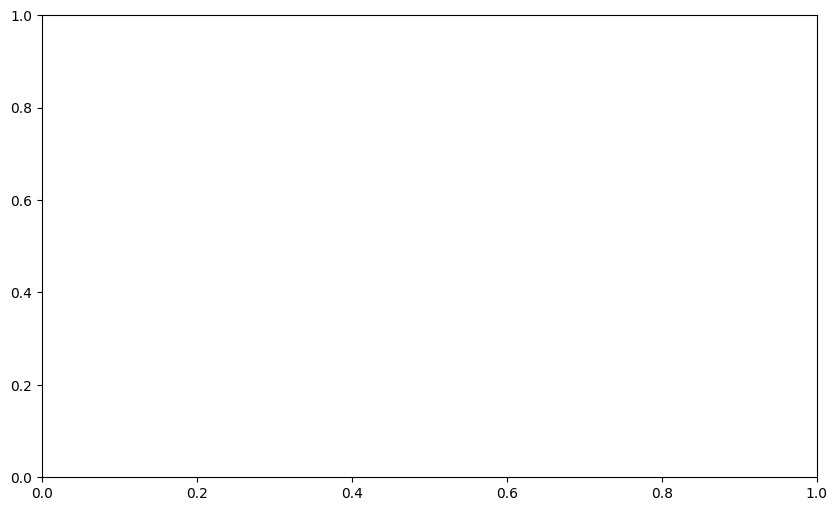

In [80]:
model.eval()  # Set the model to evaluation mode
start = 30
end = 60
all_outputs = []
all_targets = []
indices = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        # print(i, outputs, targets)
        loss = loss_function(outputs.squeeze(), targets)
        print(loss)
        
        # Store the outputs, targets, and indices for plotting
        all_outputs.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        indices.extend(range(len(inputs)))
        
        start += 1
        if start == end:
            break

# Convert lists to numpy arrays for plotting
# all_outputs = restore_price(np.array(all_outputs))
# all_targets = restore_price(np.array(all_targets))
# size = np.arange(all_outputs.shape[0])
size = len(all_outputs)

# Scatter plot of outputs vs targets
plt.figure(figsize=(10, 6))
point_size = 5
plt.scatter(size, all_outputs, color='r', label='Predicted',alpha=0.8, s=point_size)
plt.scatter(size, all_targets, color='b', label='Actual', alpha=0.5,s=point_size)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Outputs vs Targets')
plt.legend()
plt.show()



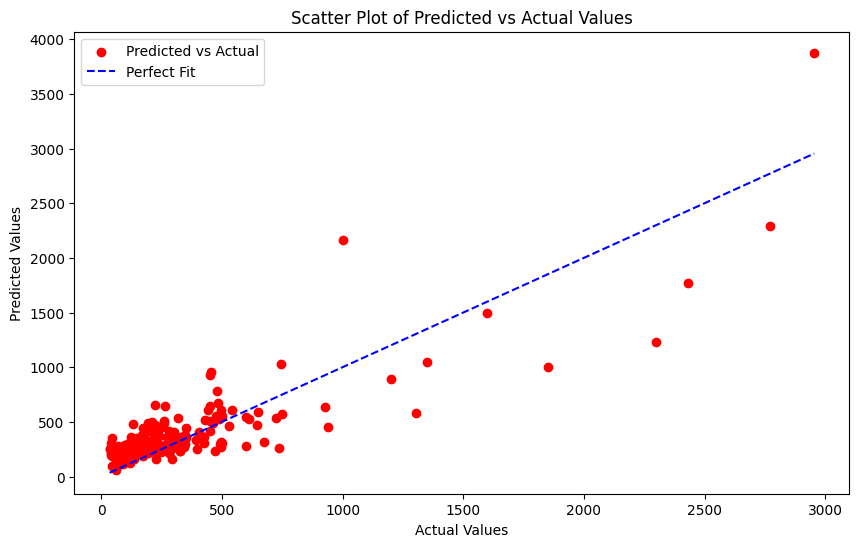

In [126]:
# Scatter plot of all_outputs vs all_targets
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_outputs, color='r', label='Predicted vs Actual')
min_val = np.min(all_targets)
max_val = np.max(all_targets)
plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='Perfect Fit')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.legend()
plt.show()

In [127]:
torch.save(model.state_dict(), 'we_model')

In [128]:
# model = simpleNN()
# model.load_state_dict(torch.load('we_model'))

<All keys matched successfully>